# Email Spam Classification

In [10]:
# Import libraries 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
nltk.download('stopwords')

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monic\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load the dataset

In [12]:
# 1. Load the dataset
df = pd.read_csv('spam_ham_dataset.csv')

In [13]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [14]:
print(f'The nº of rows in the dataset is {df.shape[0]}')
print(f'The nº of columns in the dataset is {df.shape[1]}')

The nº of rows in the dataset is 5171
The nº of columns in the dataset is 4


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


We see there are no null values in any column. There are 2 numericals and 2 categoricals Dtype.

In [17]:
df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

In [18]:
df.describe()

,Unnamed: 0,label_num
count,5171.000000,5171.000000
mean,2585.000000,0.289886
std,1492.883452,0.453753
min,0.000000,0.000000
25%,1292.500000,0.000000
50%,2585.000000,0.000000
75%,3877.500000,1.000000
max,5170.000000,1.000000


In [19]:
df.describe().T # numerical feature in a row

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,5171.0,2585.000000,1492.883452,0.0,1292.5,2585.0,3877.5,5170.0
label_num,5171.0,0.289886,0.453753,0.0,0.0,0.0,1.0,1.0


In [20]:
# Duplicated values
df.duplicated().sum()

0

In [21]:
df['label'].value_counts()

label
ham     3672
spam    1499
Name: count, dtype: int64

In [22]:
df.label_num.value_counts()

label_num
0    3672
1    1499
Name: count, dtype: int64

## Data visualization

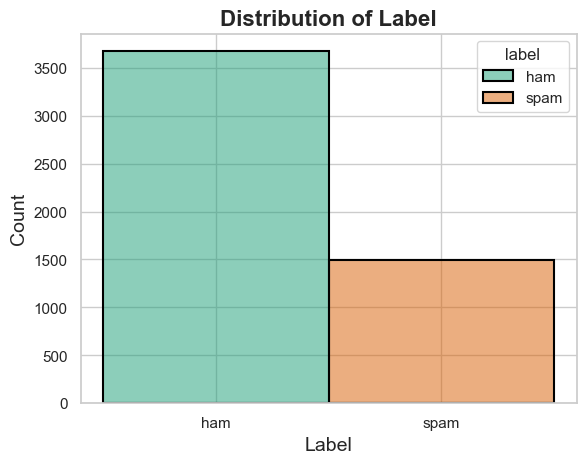

In [24]:
# Histogram

sns.set(style="whitegrid")  
sns.histplot(data = df, x = 'label', hue = 'label', palette = 'Dark2', edgecolor = 'black', linewidth = 1.5)

plt.title('Distribution of Label', fontsize = 16, fontweight = 'bold')
plt.xlabel('Label', fontsize = 14)
plt.ylabel('Count', fontsize = 14)

plt.show()

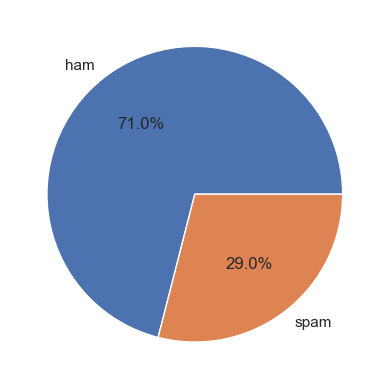

In [25]:
# Pie chart

labels = df['label'].value_counts().index # ham and spam
sizes = df['label'].value_counts().values # [3672 1499]

plt.pie(sizes, labels = labels, autopct = '%1.1f%%') # 1 decimal
plt.show()

## Preprocessing

In [27]:
df.drop(['Unnamed: 0'], axis = 1, inplace = True) # Remove unnecessary  column

In [28]:
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [29]:
X = df['text']
y = df['label_num'] # Target variable

# Split data into training and test sets
X_train_raw, X_test_raw, y_train, y_test=train_test_split(X, y ,test_size=0.2,random_state=42)
X_train_raw

5132    Subject: april activity surveys\r\nwe are star...
2067    Subject: message subject\r\nhey i ' am julie ^...
4716    Subject: txu fuels / sds nomination for may 20...
4710    Subject: re : richardson volumes nov 99 and de...
2268    Subject: a new era of online medical care .\r\...
                              ...                        
4426    Subject: re : ena sales on hpl\r\nlast that i ...
466     Subject: tenaska iv\r\nbob :\r\ni understand f...
3092    Subject: broom , bristles up , flew\r\nbe diff...
3772    Subject: calpine daily gas nomination ( weeken...
860     Subject: re : meter 1459 , 6 / 00\r\nyep , you...
Name: text, Length: 4136, dtype: object

In [30]:
def stemming_tokenizer(text):
    
    stop_words = stopwords.words('english') # all the step words in english (and,the,is...)
    stemmer = SnowballStemmer('english') # tool that reduces words to their root form

    words = re.findall(r"[A-Za-z]+", text.lower()) # list of all the words made of letters(A–Z),converted to lowercase and without punctuation or nº
    return [stemmer.stem(word) for word in words if word not in stop_words]

In [31]:
# Vectorizer with stemming:
vectorizer = TfidfVectorizer(
    tokenizer=stemming_tokenizer,      # tokenizer
    token_pattern=None,           
    ngram_range=(1,2),
    min_df=2
)
X_train = vectorizer.fit_transform(X_train_raw)
X_test  = vectorizer.transform(X_test_raw)

## ML Models

In [33]:
models = {
    "LogReg": LogisticRegression(max_iter=200, random_state=42),
    "MultinomialNB": MultinomialNB(),
    "LinearSVC": LinearSVC(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=1),
}

# We initialize variables
best_results = {}
best_model_name = None
best_accuracy = 0.0

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train) # Training the model
    y_pred = model.predict(X_test) # Predict on the test set

    accuracy = accuracy_score(y_test, y_pred) # Calculate accuracy
    best_results[name] = accuracy 

    # Accuracy and classification report for the current model
    print(f'{name} Acurracy: {accuracy:.2f}')
    print("-------------------------------------------------------")
    print(classification_report(y_test, y_pred))

    # Check if this is the best accuracy 
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model_name = name

print("\nBest Model:")
print(f"{best_model_name} with Accuracy: {best_accuracy:.2f}")

LogReg Acurracy: 0.98
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       742
           1       0.97      0.98      0.97       293

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035

MultinomialNB Acurracy: 0.96
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       742
           1       0.99      0.87      0.93       293

    accuracy                           0.96      1035
   macro avg       0.97      0.93      0.95      1035
weighted avg       0.96      0.96      0.96      1035

LinearSVC Acurracy: 0.99
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    

In [34]:
print(best_results)

{'LogReg': 0.9835748792270531, 'MultinomialNB': 0.9603864734299516, 'LinearSVC': 0.991304347826087, 'RandomForest': 0.978743961352657}


## Models accuracy visualization

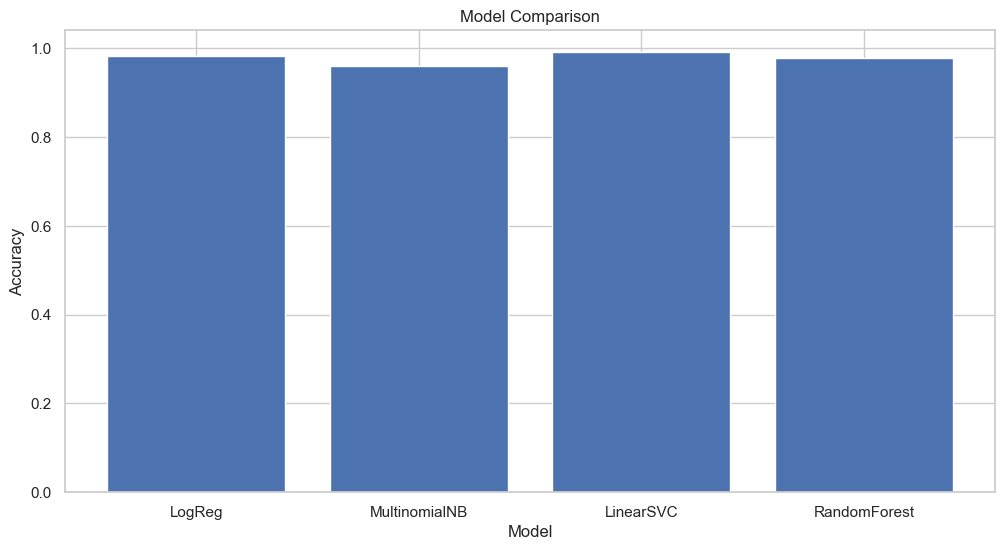

In [36]:
plt.figure(figsize = (12,6))
bars = plt.bar(best_results.keys(), best_results.values())
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

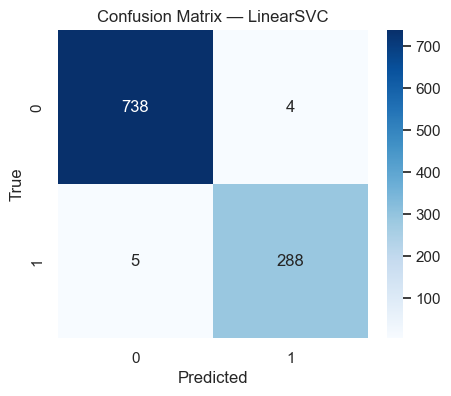

In [37]:
best_model = models[best_model_name]
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix — {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Hyperparameter tuning

In [39]:
# Best model
svc = LinearSVC(random_state=42)

# Define hyperparameter grid
param_grid = {
    "C": [0.01, 0.1, 1, 10, 100],
    "loss": ["hinge", "squared_hinge"],
    "max_iter": [1000, 2000]
}

grid = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring="f1",   # metric
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Search
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV F1:", grid.best_score_)

y_pred = grid.predict(X_test)
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best params: {'C': 1, 'loss': 'squared_hinge', 'max_iter': 1000}
Best CV F1: 0.981915832198146
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       742
           1       0.99      0.98      0.98       293

    accuracy                           0.99      1035
   macro avg       0.99      0.99      0.99      1035
weighted avg       0.99      0.99      0.99      1035



We applied GridSearchCV to fine-tune the hyperparameters of the best candidate: **LinearSVC**.

Best parameters found:
C = 1, loss = squared_hinge, max_iter = 1000